In [308]:
import pickle
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from darts.dataprocessing.transformers import Scaler

from darts import TimeSeries, concatenate
from darts.metrics import rmse

torch.manual_seed(3407)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

PREFIX = "."

In [309]:
# pure copy
N_COMPONENTS = 30
BATCH_SIZE = 8

In [310]:
# Matplotlib customizations.
plt.rc("figure", dpi=300, figsize=(9,3))
plt.rc("font", family="serif", size=6)
plt.rc("legend", edgecolor='none')

In [311]:
from darts.models import TFTModel 

In [312]:
chosen_columns = ['p', 'U:2']  # check absolute value other U:0, U:1 (done in 01_data_transform.ipynb)
sets = ['train', 'val', 'test']
TRAIN = 499
VAL = 99
TEST = 999 - TRAIN - VAL

In [313]:
def scale_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))    
    scaled_data = scaler.fit_transform(data)
    pca = PCA(n_components=N_COMPONENTS)
    reduced_data=pca.fit_transform(scaled_data)
    assert reduced_data.shape[1] == N_COMPONENTS    
    timeseries_data = TimeSeries.from_values(data)
    return scaler, pca, reduced_data

In [314]:
tables = {}
for column in chosen_columns:
    for dataset in sets:
        with open(f'{dataset}_{column}.pkl', 'rb') as f:
            print(f'{dataset}_{column}.pkl')
            if column in tables.keys():
                tables[column] = np.concatenate([tables[column], pickle.load(f)], axis=0)
            else:
                # first time read:
                tables[column] = pickle.load(f)

# discard the first data point for train, details in opinf.ipynb
for i in chosen_columns:    
    tables[i] = tables[i][:,1:]

train_p.pkl
val_p.pkl
test_p.pkl
train_U:2.pkl
val_U:2.pkl
test_U:2.pkl


In [315]:
scalers, pca, reduced_data = {}, {}, {}
for column in chosen_columns:
    print(column)
    scalers[column], pca[column], reduced_data[column] = scale_data(tables[column])

p
U:2


In [316]:
covariates = concatenate([TimeSeries.from_values(reduced_data[i]) for i in chosen_columns if i != 'p'], axis=1)

In [317]:
covariates

<TimeSeries (DataArray) (time: 999, component: 30, sample: 1)>
array([[[ 38.31082436],
        [ -0.69680253],
        [  2.50763051],
        ...,
        [  0.20379597],
        [  0.13165077],
        [  0.08842487]],

       [[ 38.22232286],
        [ -0.73700265],
        [  2.38652702],
        ...,
        [  0.18182536],
        [  0.10749742],
        [  0.07819102]],

       [[ 38.21944182],
        [ -0.7735635 ],
        [  2.290034  ],
        ...,
...
        ...,
        [  0.05047901],
        [  0.19401441],
        [  0.11250094]],

       [[ -9.9715525 ],
        [  3.21486897],
        [ -0.85029977],
        ...,
        [  0.06121137],
        [  0.21354836],
        [  0.09332596]],

       [[ -9.15407193],
        [  3.22224332],
        [ -0.84100151],
        ...,
        [  0.08128549],
        [  0.2066152 ],
        [  0.10477206]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 991 992 993 994 995 996 997 998
  * component  (component) object '0' '1' '2' '3' '4' ... '26' '27' '28' '29'
Dimensions without coordinates: sample

In [318]:
reduced_data

{'p': array([[ 7.05087467e+01,  3.25756565e+01,  3.29124473e+00, ...,
         -2.73595998e-02,  4.82466033e-04,  2.29776590e-02],
        [-4.92021790e+00,  1.20525784e+00, -2.51563490e-01, ...,
         -1.72003230e-02,  3.04828134e-02, -1.13718468e-02],
        [-5.51934770e+00,  1.29975338e+00, -6.09916049e-02, ...,
         -8.48961154e-03,  2.53526821e-02, -7.91592146e-03],
        ...,
        [-2.80885562e+00, -1.89357526e+00,  6.29774956e-02, ...,
         -6.69853841e-03, -1.56633560e-02,  2.86545341e-03],
        [-3.04781208e+00, -1.83396585e+00,  6.96741067e-02, ...,
         -9.53160816e-04, -2.69996575e-02,  3.14924068e-03],
        [-3.37260708e+00, -1.83736304e+00,  1.27849604e-01, ...,
          4.08231896e-03, -3.50938567e-02, -1.94561224e-03]]),
 'U:2': array([[ 38.31082436,  -0.69680253,   2.50763051, ...,   0.20379597,
           0.13165077,   0.08842487],
        [ 38.22232286,  -0.73700265,   2.38652702, ...,   0.18182536,
           0.10749742,   0.07819102],
 

In [319]:
time_series_list = {}
for c in chosen_columns:
    time_series_list[c] = TimeSeries.from_values(reduced_data[c])

In [320]:
INPUT_STEP = VAL   # use TEST| steps as input ....
OUTPUT_STEP = VAL  # to predict |TEST| steps as output

parameters = {
    "hidden_continuous_size": [2, 4, 8],
    "lstm_layers": [1, 2, 4],
    "dropout": [0.1, 0.3, 0.5],    
    "input_chunk_length": [INPUT_STEP],
    "output_chunk_length": [OUTPUT_STEP],
    "batch_size": [16],
    "n_epochs": [24],
    "num_attention_heads": [5, 6, 15],   # divisible by N_COMPONENTS (number of basis)
    "hidden_continuous_size": [4, 8, 16],
    "add_relative_index": [True]
}

best_model, _, _ = TFTModel.gridsearch(
    parameters = parameters,
    series = time_series_list['p'][:TRAIN],
    val_series = time_series_list['p'][TRAIN:TRAIN+VAL],
    past_covariates = covariates[:TRAIN],
    metric = rmse,
    n_jobs=16,
    verbose=True)


  0%|          | 0/81 [00:00<?, ?it/s]

[2022-07-20 23:39:00,561] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'hidden_continuous_size': 4, 'lstm_layers': 4, 'dropout': 0.1, 'input_chunk_length': 99, 'output_chunk_length': 99, 'batch_size': 16, 'n_epochs': 24, 'num_attention_heads': 15, 'add_relative_index': True}
[2022-07-20 23:39:00,561] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'hidden_continuous_size': 4, 'lstm_layers': 4, 'dropout': 0.1, 'input_chunk_length': 99, 'output_chunk_length': 99, 'batch_size': 16, 'n_epochs': 24, 'num_attention_heads': 15, 'add_relative_index': True}
2022-07-20 23:39:00 darts.models.forecasting.forecasting_model INFO: Chosen parameters: {'hidden_continuous_size': 4, 'lstm_layers': 4, 'dropout': 0.1, 'input_chunk_length': 99, 'output_chunk_length': 99, 'batch_size': 16, 'n_epochs': 24, 'num_attention_heads': 15, 'add_relative_index': True}


In [321]:
def inverse_result(timeseries: darts.TimeSeries, key):
    full_timeseries_np_array = pca[key].inverse_transform(timeseries.values())
    full_timeseries_np_array = scalers[key].inverse_transform(full_timeseries_np_array)
    return full_timeseries_np_array

In [322]:
def plot_pred(groundtruth, prediction):
    plt.plot(range(groundtruth.shape[0]), groundtruth.mean(1))
    plt.plot(range(groundtruth.shape[0]), prediction.mean(1), alpha=0.5)
    plt.legend(["groundtruth", "prediction"])

## Train on train, valid on val

In [323]:
best_params = best_model.model_params
OUTPUT_STEP = TEST
INPUT_STEP = TRAIN+VAL-TEST # maximum inplut length so that the test set can be predict in one step

best_params['input_chunk_length'] = INPUT_STEP
best_params['output_chunk_length'] = OUTPUT_STEP

In [324]:
best_params

OrderedDict([('hidden_size', 16),
             ('lstm_layers', 4),
             ('num_attention_heads', 15),
             ('full_attention', False),
             ('dropout', 0.1),
             ('hidden_continuous_size', 4),
             ('add_relative_index', True),
             ('loss_fn', None),
             ('likelihood', None),
             ('input_chunk_length', 197),
             ('output_chunk_length', 401),
             ('batch_size', 16),
             ('n_epochs', 24)])

In [325]:
best_model = TFTModel(**best_params)  # reset the model to retrain

In [326]:
best_model.fit(time_series_list['p'][:TRAIN+VAL], past_covariates=covariates[:TRAIN+VAL])

[2022-07-20 23:39:01,135] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1 samples.
[2022-07-20 23:39:01,135] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1 samples.
2022-07-20 23:39:01 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1 samples.
[2022-07-20 23:39:01,548] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-07-20 23:39:01,548] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-07-20 23:39:01 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-07-20 23:39:01 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-07-20 23:39:01 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-07-20 23:39:01 pytorch_lig

Training: 0it [00:00, ?it/s]

In [327]:
prediction = best_model.predict(n=TEST, past_covariates=covariates[:TRAIN+VAL])
reconstructed_p = inverse_result(prediction, 'p')

Predicting: 1it [00:00, ?it/s]

In [328]:
mse(reconstructed_p, tables['p'][TRAIN+VAL:], squared=False)

58.89088008417089

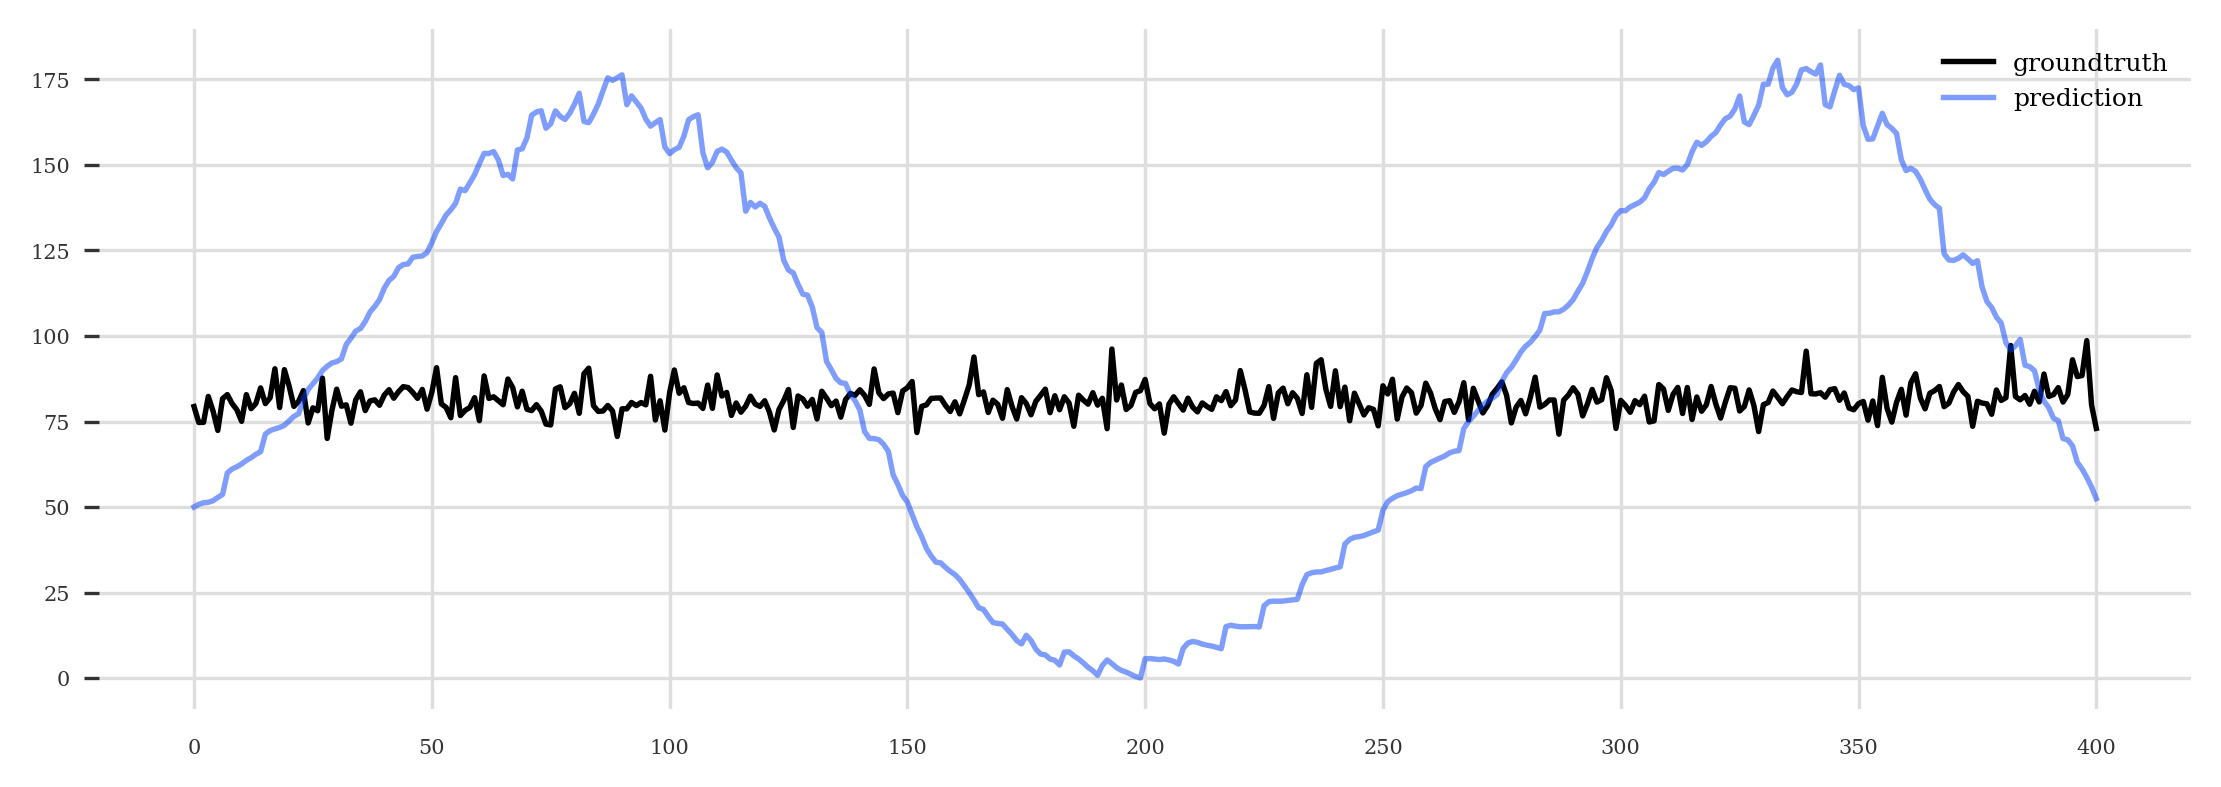

In [329]:
plot_pred(reconstructed_p, tables['p'][TRAIN+VAL:])

In [330]:
chosen_columns

['p', 'U:2']

A table for input to choose

| Feature | Test loss          |
|---------|--------------------|
| p       |  59.10807345879883 |
| p, U:2  | 58.301315879803184 |
| 'U:0', 'U:1', 'U:2',  'p'   |  59.19386363413517                 |
| 'U:0', 'U:1', 'U:2',  'p', k     |    58.90435539223949                |
| 'U:0', 'U:1', 'U:2',  'p', k, omega     |  58.852671427768875                  |
| 'U:0', 'U:1', 'U:2',  'p', k, omega, nut     |     59.24103036511967               |